## Johnatan Meoño

In [1]:
import numpy as np
import imageio as imio
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

C:\Users\Johnatan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Si tienes algún error al ejecutar la celda anterior verifica que tu ambiente de anaconda tenga las librerías necesarias.

# Clasificación con K-nearest neighbors
En este notebook vamos a implementar K-nearest neighbor, nuestro algoritmo va a **clasificar** a que raza pertenece la imagen de un perro, para entrenar nuestro algoritmo vamos a utilizar un set de datos contiene imagenes de 120 razas de perros, en total son 10,222 imagenes.

Data: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data)

#### Pre-procesamiento

El pre-procesamiento ya fue realizado y el dataset preparado y esta listo para usarse, para esto se aplico un proceso conocido como "transfer learning" usando la red neuronal "Inception" de Google(tema a cubrirse en proximas clases)  , para esta tarea ignoremos este detalle  y pensemos que se nos da un dataset con features donde cada columna representa una característica de entrada importante,pero no nos interesa conocer los detalles. 

Estas features/características fueron almacenadas en un matriz de numpy.

En esta parte del notebook solo hay que ejecutar las celdas para cargar los datos, estos datos van a servir de entrada para nuestra implementación de K-nearest neighbors con tensorflow.

### Referencias opcionales para transfer learning y "Google inception"
##### Inception
https://www.tensorflow.org/tutorials/image_recognition

https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html

##### Transfer Learning
https://www.datacamp.com/community/tutorials/transfer-learning

In [3]:
images_inception_features = './pre-processing/training_inception_features_array.npy'
training_image_labels_array = './pre-processing/training_image_labels_array.npy'
training_image_names_array = './pre-processing/training_image_names_array.npy'

In [4]:
TRAIN_DICTIONARY_KEYS = ["images", "label","features"]

training_set_dict = dict()
    
training_set_dict['images_name'] = np.load(training_image_names_array)
training_set_dict['label'] = np.load(training_image_labels_array)
training_set_dict['features'] = np.load(images_inception_features)


#  K-Nearest Neighbors

La data la vamos a manejar en los siguientes 3 arreglos: 

- features    : features de la imagen dadas por google Inception
- labels      : label de la imagen, identifica que raza es
- images_name : nombre de la imgen original, si descargan el dataset con link en la descripcion pueden buscar la imagen original por este nombre.

In [5]:
## Cargamos las features y las labes de cada feature
features = training_set_dict['features']
labels = training_set_dict['label']
images_name = training_set_dict['images_name']

In [6]:
len(features)
len(labels)
len(images_name)

10222

In [7]:
print("muestra del dataset", features)
print("rango del tensor", features.ndim)
print("tipo del tensor", type(features))
print("filas y columnas del tensor", features.shape)

muestra del dataset [[0.4150094  0.30133078 0.42465067 ... 0.05203951 0.13415624 0.50526893]
 [0.24543919 1.1325043  0.26326704 ... 0.47713736 0.06534781 0.07604624]
 [0.21103099 0.2277345  0.07869241 ... 0.24135002 0.15260082 0.13869573]
 ...
 [0.83136994 0.5540596  0.29159003 ... 0.12293872 0.02250517 0.54904526]
 [0.44555262 0.15933041 0.17165782 ... 0.22532606 0.28924143 1.8194226 ]
 [0.2348674  0.10243478 0.02458889 ... 0.17182411 2.0918512  0.13581699]]
rango del tensor 2
tipo del tensor <class 'numpy.ndarray'>
filas y columnas del tensor (10222, 2048)


Las labels pertenecientes a las features tienen el mismo indice, Ejemplo:

Caracteristicas X4:  [0.21987903 0.3616261  0.07786161 ... 0.34389263 1.2747684  0.29233742]
Caracteristicas X5:  [0.02053567 0.3619371  0.0674187  ... 0.18523939 0.5401145  0.0291276 ]
Label Y:  golden_retriever
Nombre:  0021f9ceb3235effd7fcde7f7538ed62


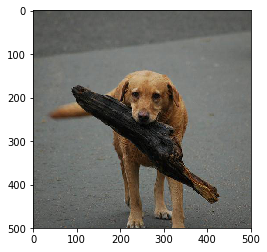

In [8]:
# Indice 4
print('Caracteristicas X4: ',features[4])
print('Caracteristicas X5: ',features[5])

print('Label Y: ',labels[4])

print('Nombre: ',images_name[4])

img = imio.imread('./data/train/'+images_name[4]+'.jpg')
plt.imshow(img)

### Implementa tu codigo de  K-Neighbors aqui:

El siguiente es un ejemplo de como puedes  definir tu función para predecir la raza sobre un punto x_predict ,a través de uscar los "k" vecinos mas cercanos en X_train y devolver como predicción el "y" que mas se repite(la moda) correspondiente a esos "k" valores de X_train , este "y" estará dado por Y_train.

Un ejemplo  de KNN en tensorflow: http://marubon-ds.blogspot.com/2017/09/knn-k-nearest-neighbors-by-tensorflow.html (este tiene diferencias, usar como guía no copiar literal, por ejemplo este usa una métrica de distancia diferente a la que debemos usar: distancia euclidiana )


#### Instrucciones:
1. Implementar KNN
2. Agregar el grafo de tensorboard
3. Ejecutar el modelo con las 2 imagenes de prueba.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn import metrics
from sklearn.cluster import KMeans
#from sklearn.datasets import fetch_openml

from sklearn.decomposition import PCA

In [10]:
features.shape

(10222, 2048)

In [11]:
print("Columnas: ", features.shape[1])

Columnas:  2048


## Etiquetado de las razas y one hot

In [12]:
grafoonehot = tf.Graph()
with grafoonehot.as_default():
    ## definiendo el vector de nombres de razas como cosntantes
    etiquetas = tf.constant(labels)
    
    ## aplicando valores unicos
    ## la "y" da los valores unicos
    ## idx indexa cada valor unico haciendo que a lo largo de los
    ## datos cada valor unico tenga el mismo indice 
    yunicos, idx = tf.unique(etiquetas)
    
    ## haciendo one hot sobre los indicses idx
    hot = tf.one_hot(idx, depth = 120)
    
    ## calcula el maximo del indice para comprobar que indexo 120 razas
    maximo = tf.reduce_max(idx)
    

In [13]:
with tf.Session(graph = grafoonehot ) as sesiononehot:
    razas, indices, ceroyuno, mayor = sesiononehot.run([yunicos, idx, hot,maximo])
    #print("Unicos:", razas)
    print("Codigos nuevos:", indices)
    print("Maximo en los Codigos nuevos:", mayor)
    print("Codigo en one hot", ceroyuno)  

Codigos nuevos: [ 0  1  2 ... 63 77 92]
Maximo en los Codigos nuevos: 119
Codigo en one hot [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
indices.shape

(10222,)

# PCA

In [15]:
#### PCA a 2 dimensiones ######
## implementar pca con sklearn
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features) #es la matriz de caracteristicas


X2D = principalComponents #new features matrix

In [16]:
X2D.shape

(10222, 2)

In [17]:
print(features.shape) ## pasadomo de esta dimension 
print(X2D.shape) ## a esta dimension

(10222, 2048)
(10222, 2)


Text(0, 0.5, 'component 2')

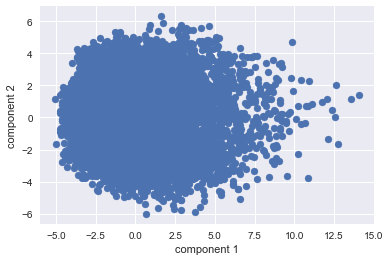

In [18]:
plt.scatter(X2D[:, 0], X2D[:, 1]) ## grafico la caractisticas las dos 
plt.xlabel('component 1')
plt.ylabel('component 2')

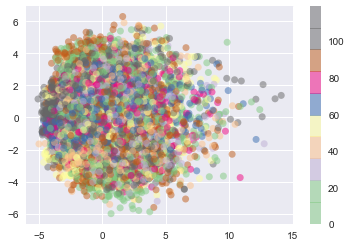

In [19]:
## no se perdio la carateristica cuando psamos de 64 a dos
plt.scatter(X2D[:, 0], X2D[:, 1],
            c=indices, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.colorbar()

## K-means Clustering con Sklearn

[Documentacion oficial](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [20]:
## K-means

In [21]:
kmeans = KMeans(n_clusters=120, random_state=0).fit(X2D) ## clustes de kmeans

In [22]:
kmeans.labels_

array([ 52,  90,  96, ...,  90,  82, 114])

In [23]:
kmeans.predict(X2D)

array([ 52,  90,  96, ...,  90,  82, 114])

In [24]:
kmeans.cluster_centers_.shape

(120, 2)

In [25]:
centers = kmeans.cluster_centers_
#clusters.cluster_centers_
print(centers)

[[-3.0061622   1.9356371 ]
 [ 2.1169646  -1.7338581 ]
 [-0.23339285 -0.99527293]
 [ 0.71754104  1.6225854 ]
 [-2.3171012  -1.2847322 ]
 [ 6.2858944   2.201757  ]
 [-0.494007    2.6595678 ]
 [ 3.590161    2.014964  ]
 [-1.1521311  -3.8805366 ]
 [ 5.8201947  -2.1175222 ]
 [-2.6890135   0.6995961 ]
 [ 2.6936636  -3.6689768 ]
 [-1.7303668  -0.07575449]
 [ 0.79577583  0.09899305]
 [ 0.84125537  4.2032995 ]
 [ 0.3973788  -2.2506828 ]
 [ 2.6219246   0.8940319 ]
 [-1.3753965  -2.299109  ]
 [ 4.5933867   0.09808974]
 [-1.8396616   2.636582  ]
 [ 6.7778654  -0.12393897]
 [-1.1659999   1.046692  ]
 [12.783       0.4075304 ]
 [-0.33972117  3.6401966 ]
 [-4.1515     -0.63145876]
 [ 1.6868453   2.5209918 ]
 [-0.5461828  -0.18135694]
 [-3.0714781  -1.6964687 ]
 [ 0.49318868 -0.76067656]
 [ 8.995254   -0.2776909 ]
 [ 3.7726593   3.1256626 ]
 [-1.1302555  -0.4274651 ]
 [ 0.6570483  -3.9526224 ]
 [-2.1561818   3.3375652 ]
 [-1.620612    1.5403441 ]
 [ 5.177672   -3.0982714 ]
 [ 2.8910046  -2.5714037 ]
 

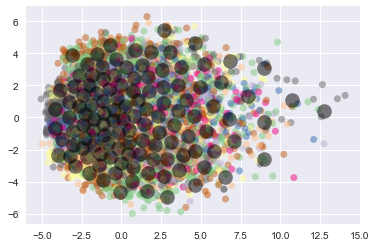

In [26]:
plt.scatter(X2D[:, 0], X2D[:, 1],
            c=indices, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.scatter(centers [:, 0], centers [:, 1], c='black', s=200, alpha=0.5);

## t-SNE

In [27]:
## esta llamanada sirve para la fucion que separara datos 
from sklearn.model_selection import train_test_split

In [31]:
## separacion de datos 
features_menor, test = train_test_split(features, test_size=0.90)

In [32]:
features_menor

array([[1.02443188e-01, 1.79812267e-01, 1.06747024e-01, ...,
        5.73549271e-02, 1.54175267e-01, 1.13750644e-01],
       [2.00051054e-01, 4.73206460e-01, 9.24224108e-02, ...,
        5.05281448e-01, 2.40299284e-01, 1.47009045e-01],
       [3.28336746e-01, 9.52257439e-02, 2.61714607e-01, ...,
        1.03799865e-01, 9.90946516e-02, 2.38343418e-01],
       ...,
       [3.67639244e-01, 3.21766958e-02, 3.92032146e-01, ...,
        4.75383177e-02, 3.41235176e-02, 1.35693117e-03],
       [2.75573462e-01, 2.02791244e-01, 9.42943916e-02, ...,
        1.14913240e-01, 4.96030494e-04, 2.42343843e-01],
       [4.72298920e-01, 2.80810744e-01, 9.42076817e-02, ...,
        7.09545374e-01, 5.48564672e-01, 2.30517700e-01]], dtype=float32)

In [33]:
features_menor.shape

(1022, 2048)

In [34]:
from sklearn.manifold import TSNE

In [35]:
tsne = TSNE(n_components=2,n_iter=250)

In [36]:
componente_principal = tsne.fit_transform(features)

Text(0, 0.5, 'component 2')

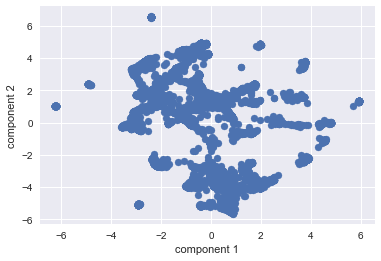

In [37]:
plt.scatter(componente_principal[:, 0], componente_principal[:, 1]) ## grafico la caractisticas las dos 
plt.xlabel('component 1')
plt.ylabel('component 2')

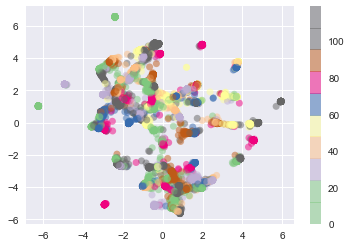

In [38]:
## no se perdio la carateristica cuando psamos de 64 a dos
plt.scatter(componente_principal[:, 0], componente_principal[:, 1],
            c=indices, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.colorbar()

In [39]:
componente_principal

array([[-3.5665772 , -0.24900174],
       [ 0.30292308,  1.3945402 ],
       [ 3.5250957 , -2.5507808 ],
       ...,
       [-0.99795586, -3.9699788 ],
       [-0.546388  ,  1.4360857 ],
       [-2.3401568 ,  1.9511982 ]], dtype=float32)

## K-means Clustering con Sklearn

[Documentacion oficial](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [40]:
kmeanss = KMeans(n_clusters=120, random_state=0).fit(componente_principal) ## clustes de kmeans

In [41]:
kmeanss.labels_

array([ 63, 114,  17, ...,  16,  81,  30])

In [42]:
kmeanss.predict(componente_principal)

array([ 63, 114,  17, ...,  16,  81,  30])

In [43]:
kmeanss.cluster_centers_.shape

(120, 2)

In [44]:
centerss = kmeanss.cluster_centers_
#clusters.cluster_centers_
print(centerss)

[[ 0.54167485 -3.4485784 ]
 [-2.6460238   3.7616296 ]
 [ 0.624561    0.77376425]
 [ 3.6934335   3.4328377 ]
 [-2.677984    0.8501979 ]
 [ 4.395191   -0.0960919 ]
 [-2.2547784  -2.5744972 ]
 [-0.42100868  4.898672  ]
 [ 0.83189553 -5.5499654 ]
 [ 2.479525   -3.5644991 ]
 [-0.626714    1.1022395 ]
 [-0.0070986  -1.28531   ]
 [ 1.7230223   2.3526306 ]
 [-2.106043    2.6456714 ]
 [-6.23227     1.0267998 ]
 [ 1.2901083  -0.64277744]
 [-0.94473535 -3.9536579 ]
 [ 3.7083519  -2.413252  ]
 [-0.6488337   1.9663472 ]
 [ 3.6672988   1.594084  ]
 [-2.39084     6.567497  ]
 [-2.9120228  -5.083924  ]
 [-0.82077605 -0.08485304]
 [ 1.9711856   4.8321886 ]
 [-0.20498969 -2.7506318 ]
 [ 5.924403    1.3072897 ]
 [ 2.7182193  -0.0121873 ]
 [-4.906301    2.3789017 ]
 [-3.2079418  -0.3330823 ]
 [-0.92462444  4.4638243 ]
 [-2.3665462   1.8477916 ]
 [ 1.4007672  -2.8201647 ]
 [ 1.9558909  -4.026917  ]
 [ 1.3647099   1.3266273 ]
 [ 0.58232397 -5.079764  ]
 [ 4.5570498  -1.1093373 ]
 [ 1.2095028  -4.109164  ]
 

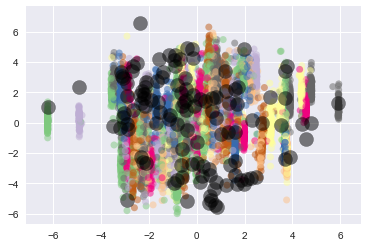

In [45]:
plt.scatter(componente_principal[:, 0], X2D[:, 1],
            c=indices, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.scatter(centerss [:, 0], centerss [:, 1], c='black', s=200, alpha=0.5);

# Diferencias y Similitudes

### PCA trasnforma vectores a matrices hace uso de Eigen vectores y de SVD. Este metodo de reducción normaliza datos centrados en 0  con desviacion estandar 1. Luego calcula la matriz de covarianzas, luego calcula los eigen vectores. Al final la matriz de caracteristicas reducidas es el resultado de multiplicar la matriz de eigen vectores trasnpuesta por la matriz de caracteristicas original. PCA busca mantener la estructura general

### t-SNE ayuda a la reducción de dismesionalidad, para visualizacion de datos, es un modelo reciente, posee la misma idea que PCA pero este busca matener la estructura local. Es decir los vecinos seran vecinos antes y despues de la transformación. t-SNE es un modelo muy usado en modelos que convierten texto a vectores. Este no esta basado en algebral lineal esta basado en probabilidad. t-SNE calcula la probabilidad de que pares de puntos sean vecinos, usando kullback-Leiber, cero es que son iguales y es un metodo iterativo. Aca se minimiza lal divergencia usando gradient descent. Utiliza hiperparametros como el learning rate. Es un metodo que requiere mucha capacidad computacional por lo que la presentación de resultados se demora. 